In [1]:
# %matplotlib notebook
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt, calendar
import os

# import seaborn as sns

# Introduction

Notebook for initial exploration of the daily data used in Bayesian Network development in Lake Vansjø.

Things to think about in the future:
- Lake N species
- Lake DIN:TP or TN:TP (see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3996004/ for justification of which ratio to use)

# Read in data

In [2]:
# User input
# Which Vansjø basin? Van1 (Storefjorden), Van2 (Vanemfjorden)
basin = 'Van2'

# Include TP flux estimates in the data matrix?
inc_fluxes = 0  # 0 or 1

# Include features from Van1 in Van2's features? Only relevant if basin is Van2
inc_Van1 = 1

# FILE PATHS to input data

# Met (T, pptn)
met_fpath = r'../../../Data/Meteorological/Obs_metno/Obs_Metno_1km_gridded_Morsa_v2.csv'
wind_fpath = r'../../../Data/Meteorological/Obs_metno/Obs_Rygge_MeanWindSpeed.csv'  # Mean daily wind speed (m/s), Rygge airport
PET_fpath = r'../../Data/ExploratoryInput/Morsa_ThornthwaitePET.csv'  #N.B. calculated using met station temp rather than gridded. But the two are v. comparable (not so pptn)

# Discharge
Q_fpath = r'../../../Data/Discharge/3-22-0_D6pm_Hogfoss_Scaled_to_Kure.csv'

# Catchment water quality (at Kure)
catchwq_fpath = r'../../../Data/Observed_Chem_Ecol/003-59191_Hobølelva_Kure_chem_obs.csv'

# Lake water quality
lakewq_fpath_dict = {'Van1': r'../../Data/ExploratoryInput/Van1_Storefjorden_chem_obs_to2017.csv',
                     'Van2': r'../../../Data/Observed_Chem_Ecol/Van2_Vanemfjorden_chem_obs.csv'}
lakewq_fpath = lakewq_fpath_dict[basin]

# Alternative lake colour data (from Storefjorden, 20m depth, MOVAR data)
movar_color_fpath = r'../../../Data/Observed_Chem_Ecol/LakeColour_MOVAR.csv'

# Lake ecology (PTI, biovolume, cyanomax, cyano biovolume)
ecol_fpath_dict = {'Van1': r'../../Data/ExploratoryInput/Van1_PTI_Cyano_to2018.xlsx',
                   'Van2':  r'../../../Data/Observed_Chem_Ecol/Van2_Vanemfjorden_Cyanobacteria.csv'}
ecol_fpath = ecol_fpath_dict[basin]

In [3]:
# READ IN
met_df = pd.read_csv(met_fpath, index_col=0, parse_dates=True, dayfirst=True)
pet_df = pd.read_csv(PET_fpath, index_col=0, parse_dates=True, dayfirst=True)
wind_df = pd.read_csv(wind_fpath, index_col=0, parse_dates=True, dayfirst=True)

Q_df = pd.read_csv(Q_fpath, index_col=0, parse_dates=True, dayfirst=True)

catchwq_df = pd.read_csv(catchwq_fpath, index_col=0, parse_dates=True, dayfirst=True)

lakewq_df = pd.read_csv(lakewq_fpath, index_col=0, parse_dates=True, dayfirst=True)
color_df = pd.read_csv(movar_color_fpath, index_col=0, parse_dates=True, dayfirst=True)

# If looking at Van2 (Vanemfjorden), also read in lake data from Storefjorden
if basin == "Van2" and inc_Van1 == 1:
    lakewq_df_van1 = pd.read_csv(
        lakewq_fpath_dict["Van1"], index_col=0, parse_dates=True, dayfirst=True
    )

# Read in ecol data from excel sheet one sheet at a time, then merge
if basin == "Van1":
    # Haven't updated Van1 beyond 2018
    ecol_fpath = ecol_fpath_dict["Van1"]
    PTI_df = pd.read_excel(ecol_fpath, sheet_name=0, index_col=3, parse_dates=True)
    biovol_df = pd.read_excel(ecol_fpath, sheet_name=1, index_col=3, parse_dates=True)
    cyanoBiovol_df = pd.read_excel(
        ecol_fpath, sheet_name=2, index_col=0, parse_dates=True
    )
    ecol_df = pd.concat(
        [
            PTI_df["PTI"],
            biovol_df["Biovolume_mm3_per_l"],
            cyanoBiovol_df["Cyano_biovol_mm3_per_l"],
        ],
        axis=1,
    )
else:
    # For Van2, haven't updated PTI or biovolume data to 2019, only cyanobiovol
    ecol_fpath = ecol_fpath_dict["Van2"]
    ecol_df = pd.read_csv(ecol_fpath, index_col=0, parse_dates=True, dayfirst=True)
    # convert units to mm3/l (mg/l if assume density is same as water)
    ecol_df["Cyano_biovol_mm3_per_l"] = ecol_df["Cyano_biovol_mm3_per_m3"] / 1000.0
    ecol_df.drop(["Cyano_biovol_mm3_per_m3"], axis=1, inplace=True)

# Some quality control and visualisation

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

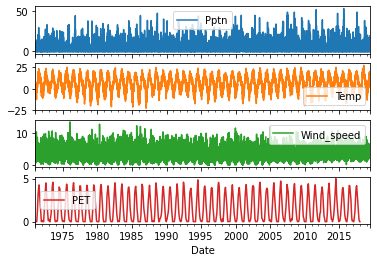

In [4]:
# For the met data, just pick the columns of interest and rename them
met_df = met_df[
    ["RR_catch", "TG_catch"]
]  # For now, pick rainfall and temp averaged over whole catchment, not just the lake
met_df.columns = ["Pptn", "Temp"]
met_df.index.name = "Date"
met_df.index = met_df.index.normalize()  # Drop time info from metdf index

# Add mean daily wind speed (m/s)
met_df["Wind_speed"] = wind_df.iloc[:, 0]

# Also add PET (mm/day)
met_df["PET"] = pet_df["PET"]

met_df.plot(subplots=True)

<AxesSubplot:xlabel='Date'>

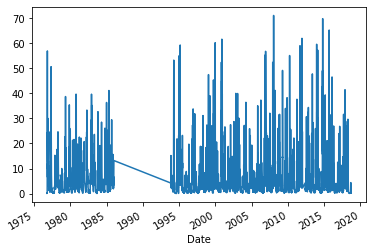

In [5]:
Q_df = Q_df['Q_18H_average_m3s_scaled']
Q_df.rename('Q', inplace=True)
Q_df.plot()

<AxesSubplot:xlabel='Date'>

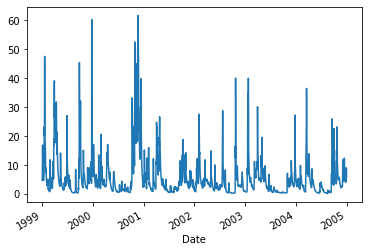

In [6]:
# Quick look at the autumn 2000 flood, thought to have caused the algal blooms in the period 2001-2007
Q_df.loc['1999-01-01':'2005-01-01'].plot()

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

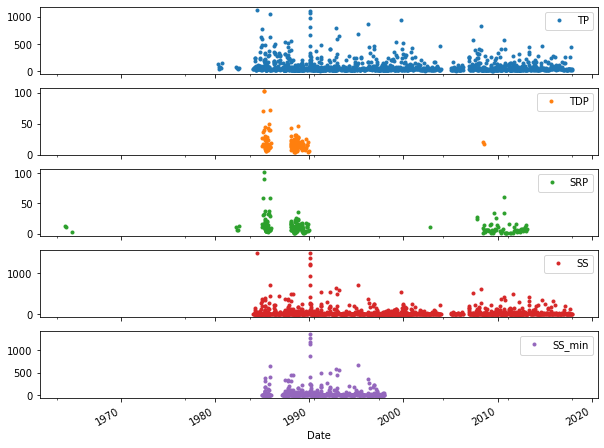

In [7]:
catchwq_df.plot(subplots=True, style='o', ms=3, figsize=(10,8))

<AxesSubplot:xlabel='Date'>

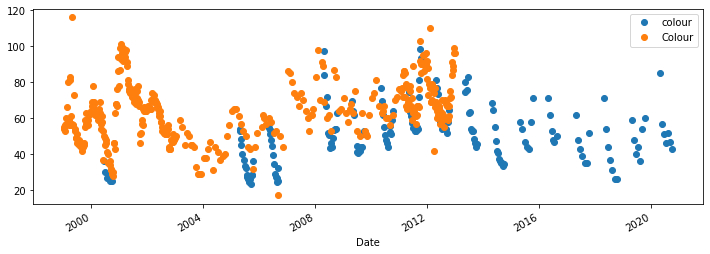

In [8]:
# Compare NIVA and MOVAR colour data (MOVAR data is shorter)

lakewq_df = pd.merge(
    lakewq_df, color_df, left_index=True, right_index=True, how="outer"
)

lakewq_df.loc["1998-01-01":, ["colour", "Colour"]].plot(style="o", figsize=(12, 4))

# Optionally output to csv for quick stats elsewhere
# lakewq_df.loc['1998-01-01':,['colour','Colour']].dropna().to_csv(r'../data/lake_colour_comparison.csv')

Text(0.5, 0, 'MOVAR colour')

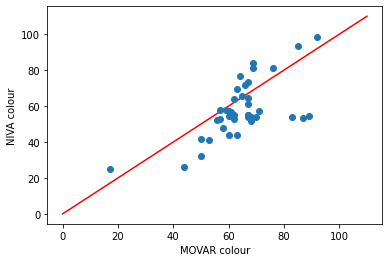

In [9]:
l = np.arange(0, 120, 10)
plt.plot(l, l, "r-")

plt.plot(lakewq_df["Colour"], lakewq_df["colour"], "o")
plt.ylabel("NIVA colour")
plt.xlabel("MOVAR colour")

# plt.show()

**Colour**: MOVAR data covers much more of the period 2000-2012 than the NIVA data. However, stops in 2012. How to make a continuous time series for the period overlapping with the cyanobacteria observations (i.e. 1998-2018)? Want to use the MOVAR data and then the NIVA data, or a combination of the two. However, they are sampled from different lakes and depths (MOVAR data is from 20m deep in Storefjorden, NIVA data from the top 0-3m in Vanemfjorden). We can see they follow the same broad pattern between years and seasonally, but there are often offsets in the timing of rising and falling limbs (though this is most apparent in 2005-7, not so much in later years).

For now, **Just merge the two datasets**. But a mroe rigorous statistical comparison of the two datasets (or just getting hold of MOVAR data for the entire period) would be much preferable.

<AxesSubplot:xlabel='Date'>

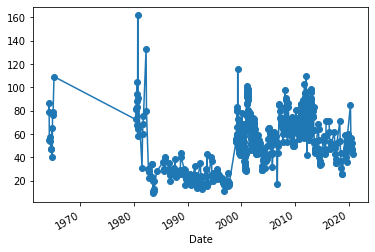

In [10]:
# Before Jan 1999: NIVA data, Jan 1999- end 2012: Movar data, from Jan 2013: NIVA data
s0 = lakewq_df.loc[:"1998-12-31", "colour"]

id1 = lakewq_df["Colour"].first_valid_index()
s1 = lakewq_df["Colour"].loc[id1:]
s1.name = "colour"

lastidx = lakewq_df.loc["2013-01-01":, "colour"].last_valid_index()
s2 = lakewq_df.loc["2013-01-01":lastidx, "colour"]

colour = pd.concat([s0, s1, s2], axis=0).dropna()
colour.plot(style="o", linestyle="-")

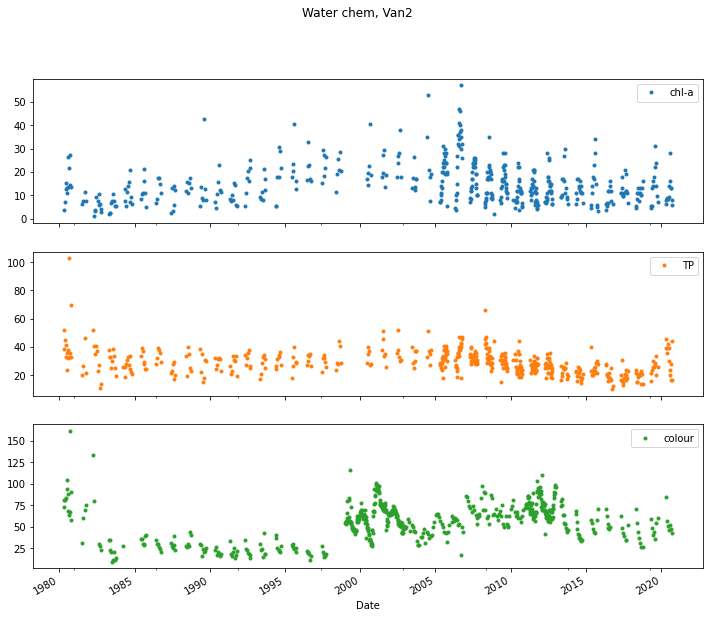

In [11]:
# Drop original MOVAR and NIVA colour series, and replace with the patched series
lakewq_df = lakewq_df.drop(["colour", "Colour"], axis=1)
lakewq_df = lakewq_df.merge(
    colour.to_frame(), left_index=True, right_index=True, how="outer"
)

lakewq_df.loc["1980-01-01":, :].plot(subplots=True, style="o", ms=3, figsize=(12, 10))
plt.suptitle("Water chem, %s" % basin)
# plt.savefig(r'../Figures/lake_chem_timeseries_%s.png' %basin)
plt.show()

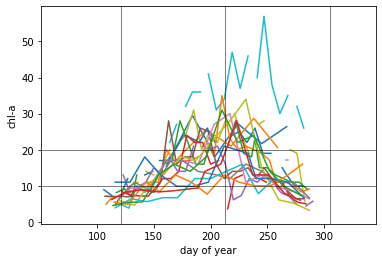

In [12]:
# Take a look at seasonality

var = "chl-a"
fig = plt.figure()
ax = fig.add_subplot(111)
df_to_group = lakewq_df.loc["1997-01-01":, :]

for group in df_to_group.groupby(df_to_group.index.year):
    linename = group[0]
    data = group[1][var]
    data.index = data.index.dayofyear
    data.plot(ax=ax, style="-")

start_May = 121
start_Aug = 213
start_Nov = 305
ax.axvline(x=start_May, color="k", lw=0.5)
ax.axvline(x=start_Aug, color="k", lw=0.5)
ax.axvline(x=start_Nov, color="k", lw=0.5)

ax.axhline(y=10, color="k", lw=0.5)
ax.axhline(y=20, color="k", lw=0.5)

plt.ylabel(var)
plt.xlabel("day of year");

**Seasonality:**
At Van2: TP over the summer generally roughly constant, sometimes increasing, sometimes increasing and then decreasing again.

At Van1: TP almost always starts high and then decreases over the summer

Perhaps because there's not as much stratification at the shallower Van2, so the top layer doesn't get depleted, and have more replenishment of TP from sediment-water interactions?

array([<AxesSubplot:xlabel='Date'>], dtype=object)

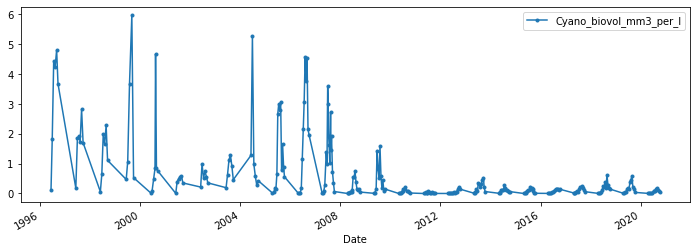

In [13]:
ecol_df.plot(subplots=True, style='o', ls='-', ms=3, figsize=(12,4))

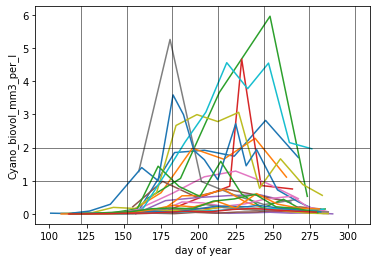

In [14]:
# Take a look at seasonality

var = "Cyano_biovol_mm3_per_l"
fig = plt.figure()
ax = fig.add_subplot(111)
df_to_group = ecol_df.loc["1997-01-01":, :]

for group in df_to_group.groupby(df_to_group.index.year):
    linename = group[0]
    data = group[1][var]
    data.index = data.index.dayofyear
    data.plot(ax=ax, style="-")

start_of_month_li = 121, 152, 182, 213, 244, 274, 305
for day in start_of_month_li:
    ax.axvline(x=day, color="k", lw=0.5)

ax.axhline(y=1, color="k", lw=0.5)
ax.axhline(y=2, color="k", lw=0.5)

plt.ylabel(var)
plt.xlabel("day of year");

**Comments:**

Van1 & Van2:
- Earliest lake data is in 1980, so drop all data from everything before then

- Dodgy data to be removed/not used:

    - Lake colour pre-August 1982
    - Lake dissolved P for Vansjø (TDP and SRP) show a big step-change between around 1998 and 2004. Not clear whether this is real, or either one side or the other of the step should be discarded. TP doesn't show this change. So for now only use TP and assume all dissolved P data (TDP, SRP) is dodgy
    - Mostly for plotting purposes, remove outliers from SS (and SS_min for Van1) (lake data): above 20 mg/l

- Precipitation data has one negative value; set to 0

Otherwise looks ok at first glance (aside from occasional outlier)

In [15]:
# # Data cleaning based on plots above

# lakewq_df.loc[:'1982-08-01','colour'] = np.NaN
# lakewq_df[lakewq_df[['SS','SS_min']]>25.] = np.NaN
# met_df.loc[met_df['Pptn']<0.,'Pptn'] = 0.

# if basin == 'Van2':
#     lakewq_df_van1.loc[:'1982-08-01','colour'] = np.NaN

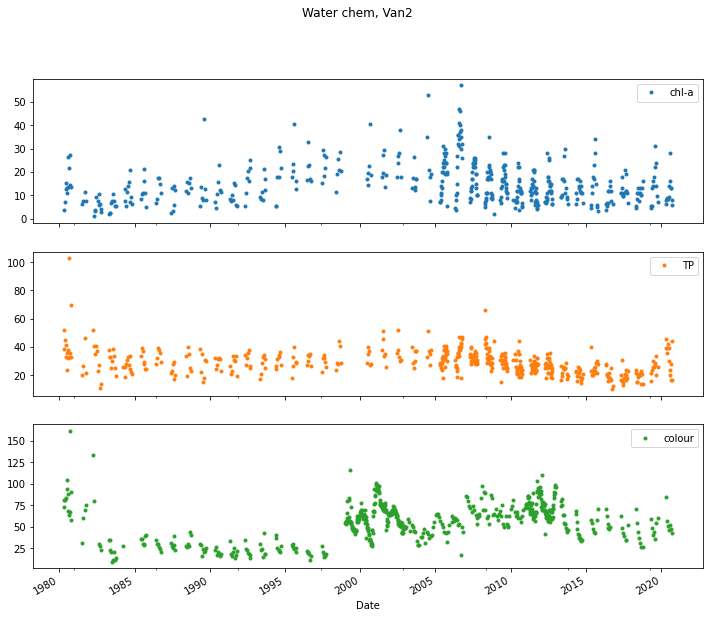

In [16]:
# Replot to see how it looks now

lakewq_df.loc["1980-01-01":, :].plot(subplots=True, style="o", ms=3, figsize=(12, 10))
plt.suptitle("Water chem, %s" % basin)
# plt.savefig(r'../Figures/lake_chem_timeseries_%s.png' %basin)
plt.show()

# Combine data and add seasonal info

In [17]:
# Add suffixes to lake and water quality columns
catchwq_df = catchwq_df.add_suffix('_catch')
lakewq_df = lakewq_df.add_suffix('_lake')

if basin == 'Van2':
    lakewq_df_van1 = lakewq_df_van1.add_suffix('_van1')

In [18]:
# REINDEX & JOIN ALL DATASETS INTO ONE DATAFRAME

if basin == "Van2":
    df_list = [met_df, Q_df, catchwq_df, lakewq_df, ecol_df, lakewq_df_van1]
else:
    df_list = [met_df, Q_df, catchwq_df, lakewq_df, ecol_df]

for i, df in enumerate(df_list):
    df = df.reindex(index=met_df.index)
    if i < 1:
        daily_df = df
    else:
        daily_df = daily_df.join(df)

# Remove data pre-1980
daily_df = daily_df.loc["1980-01-01":, :]

daily_df.columns.values

array(['Pptn', 'Temp', 'Wind_speed', 'PET', 'Q', 'TP_catch', 'TDP_catch',
       'SRP_catch', 'SS_catch', 'SS_min_catch', 'chl-a_lake', 'TP_lake',
       'colour_lake', 'Cyano_biovol_mm3_per_l', 'colour_van1',
       'chl-a_van1', 'TP_van1', 'SS_min_van1', 'SS_van1', 'TOC_van1',
       'TDP_van1'], dtype=object)

In [19]:
# Drop some cols and rename others

if basin == "Van2":
    cols_to_drop = [
        "SS_min_catch",
        "SS_catch",
        "TDP_catch",
        "SRP_catch",
        "TOC_van1",
        "TDP_van1",
        "SS_min_van1",
        "SS_van1",
    ]
else:
    cols_to_drop = ["SS_min_catch", "SS_catch", "TDP_catch", "SRP_catch"]

var_rename_dict = {
    "Biovolume_mm3_per_l": "Biovolume",
    "Cyano_biovol_mm3_per_l": "CyanoBiovol",
}

daily_df.drop(cols_to_drop, axis=1, inplace=True)
daily_df.rename(var_rename_dict, axis=1, inplace=True)

print(daily_df.columns.values)

['Pptn' 'Temp' 'Wind_speed' 'PET' 'Q' 'TP_catch' 'chl-a_lake' 'TP_lake'
 'colour_lake' 'CyanoBiovol' 'colour_van1' 'chl-a_van1' 'TP_van1']


# Plot

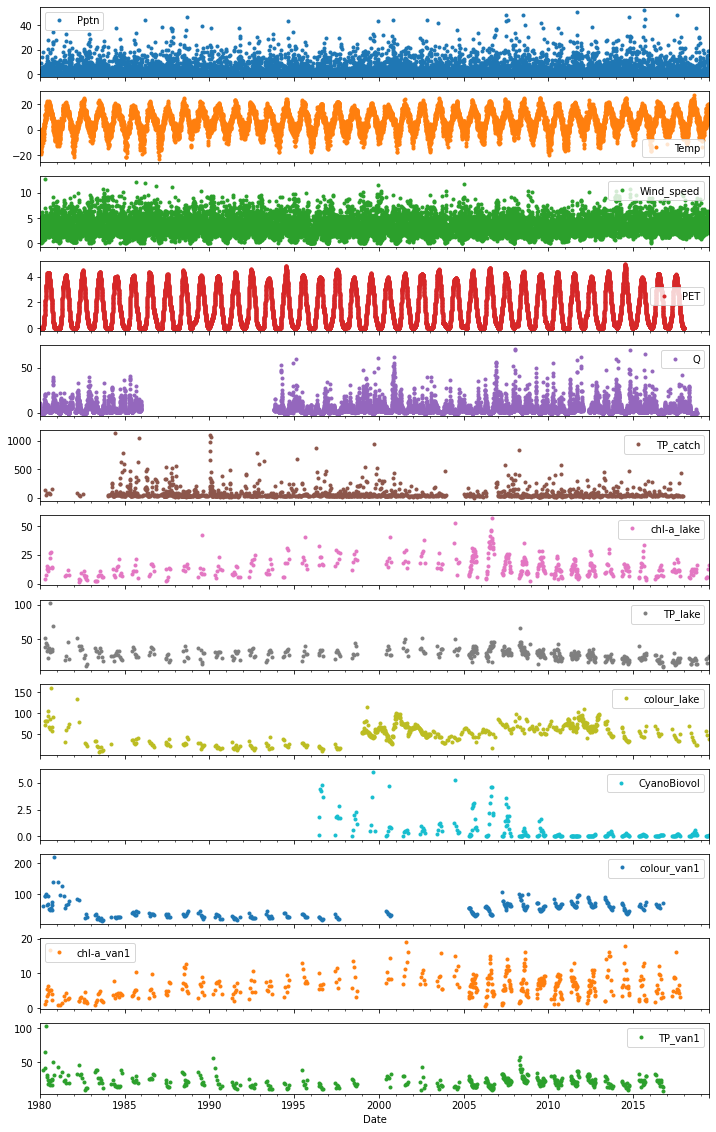

In [20]:
daily_df.loc["1980-01-01":, :].plot(subplots=True, style="o", ms=3, figsize=(12, 20));

# Look at number of samples over time

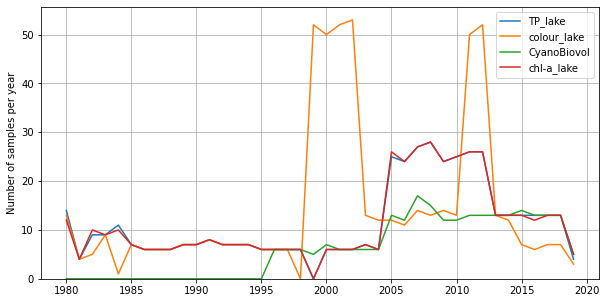

In [21]:
count_df = pd.DataFrame()
target_vars = ["TP_lake", "colour_lake", "CyanoBiovol", "chl-a_lake"]
for group in daily_df[target_vars].groupby(daily_df.index.year):
    year = group[0]
    year_df = group[1]
    count_df[year] = year_df.count()

count_df.transpose().plot(figsize=(10, 5), grid=True)
plt.ylabel("Number of samples per year")
plt.ylim(ymin=0);

In [22]:
# How many data points do we have, and how many are missing?


def missing_data(df):
    # Number of missing in each column
    missing = pd.DataFrame(df.isnull().sum()).rename(columns={0: "N_missing"})

    # Number of data points & percent missing
    missing["N_data"] = df.notna().sum()
    missing["percent_missing"] = missing["N_missing"] / len(df)

    missing = missing.sort_values("percent_missing", ascending=False)
    return missing


missing_data(daily_df)

,N_missing,N_data,percent_missing
CyanoBiovol,14180,245,0.983016
colour_van1,14138,287,0.980104
TP_van1,13986,439,0.969567
chl-a_van1,13980,445,0.969151
chl-a_lake,13969,456,0.968388
TP_lake,13968,457,0.968319
colour_lake,13841,584,0.959515
TP_catch,13043,1382,0.904194
Q,3853,10572,0.267106
PET,545,13880,0.037782


# Add derived variables from daily data

In [23]:
# Add derived variables from daily data

# Proxy for lake residence time (assume volume is constant, and so
# residence time is proportional to 1/outflow, and that outflow is
# proportional to discharge at Kure)
daily_df["rel_res_time"] = 1 / daily_df["Q"]

if inc_fluxes == 1:

    # Daily TP flux (rough estimate only!)
    # First, rough interpolation of TP concentration from Kure to daily
    TP_interp = (
        daily_df["TP_catch"].resample("D").interpolate(method="linear", limit=31)
    )

    fig = plt.figure(figsize=(9, 6))

    ax0 = fig.add_subplot(3, 1, 1)
    daily_df["Q"].plot(ax=ax0)
    plt.ylabel("Q (m3/s)")

    ax1 = fig.add_subplot(3, 1, 2)
    TP_interp.plot(ax=ax1)
    plt.ylabel("Kure [TP] interp (ug/l)")
    daily_df["TP_catch"].plot(ax=ax1, style="r.")
    # Calc flux (kg/day)
    daily_df["TP_flux"] = daily_df["Q"] * TP_interp * 86400 * (10**-6)

    ax2 = fig.add_subplot(3, 1, 3)
    daily_df["TP_flux"].plot(ax=ax2)
    plt.ylabel("Kure TP flux (kg/d)")

    daily_df["TP_flux"].describe()

## Precipitation features

In [24]:
# (1) rain day (boolean of whether it rained that day or not)
def rain_day(pptn):
    if pptn > 0.0:
        return 1
    else:
        return 0


daily_df["Rain_day"] = daily_df["Pptn"].map(rain_day)
print(daily_df[["Pptn", "Rain_day"]].head())

                Pptn  Rain_day
Date                          
1980-01-01  0.000000         0
1980-01-02  0.000000         0
1980-01-03  0.000000         0
1980-01-04  2.669136         1
1980-01-05  2.806878         1


8.499137083600006
                Pptn  Pptn_intense
Date                              
1980-01-01  0.000000             0
1980-01-02  0.000000             0
1980-01-03  0.000000             0
1980-01-04  2.669136             0
1980-01-05  2.806878             0


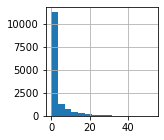

In [25]:
# (2) pptn intensity: Boolean saying whether precipitation is above a certain threshold
# First, take a look at the distribution of rainfall to decide on the threshold
daily_df["Pptn"].hist(bins=15, figsize=(2, 2))
print(daily_df["Pptn"].quantile(q=0.90))

# Decide to use threshold of 90th percentile, 8.2 mm/day
def rain_intense(pptn):
    if pptn > 8.2:
        return 1
    else:
        return 0


daily_df["Pptn_intense"] = daily_df["Pptn"].map(rain_intense)
print(daily_df[["Pptn", "Pptn_intense"]].head())

## Wind speed
Median daily wind speed is 3.3 m/s, and the distribution is somewhat right skewed. The main thing that is likely to be important for cyanobacteria is a stable upper water column, which affects the competitive balance between cyanobacteria and other species. The duration of the stable upper water column could also be important, so features could be e.g. x days below whatever wind speed threshold is required for a stable upper water column, AND no (potentially short-lived) periods where the water column is mixed due to high winds.

Q0.1: 1.5 m/s
Q0.2: 2.0 m/s
Q0.3: 2.4 m/s
Q0.4: 2.9 m/s
Q0.5: 3.3 m/s


Q0.5: 3.3 m/s
Q0.6: 3.8 m/s
Q0.7: 4.2 m/s
Q0.8: 4.8 m/s
Q0.9: 5.8 m/s
            Wind_speed  Wind_under_Q0.2  Wind_over_Q0.5
Date                                                   
1980-01-01         2.9            False           False
1980-01-02         3.1            False           False
1980-01-03         1.5             True           False
1980-01-04         1.7             True           False
1980-01-05         1.5             True           False


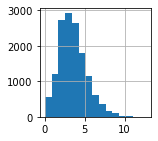

In [26]:
# Wind features: Boolean saying whether wind speed was above or below a certain threshold

# Distribution of wind speed
daily_df["Wind_speed"].hist(bins=15, figsize=(2, 2))

# Define 'calm day' features
calm_quantiles = [0.1, 0.2, 0.3, 0.4, 0.5]
for quantile in calm_quantiles:
    upper_threshold = daily_df["Wind_speed"].quantile(quantile)
    print("Q%s: %s m/s" % (quantile, upper_threshold))
    daily_df["Wind_under_Q%s" % quantile] = daily_df["Wind_speed"] < upper_threshold

print("\n")

# Define 'windy day' features
windy_quantiles = [0.5, 0.6, 0.7, 0.8, 0.9]
for quantile in windy_quantiles:
    lower_threshold = daily_df["Wind_speed"].quantile(quantile)
    print("Q%s: %s m/s" % (quantile, lower_threshold))
    daily_df["Wind_over_Q%s" % quantile] = daily_df["Wind_speed"] > lower_threshold

print(daily_df[["Wind_speed", "Wind_under_Q0.2", "Wind_over_Q0.5"]].head())

Text(0, 0.5, 'Daily mean wind speed (m/s)')

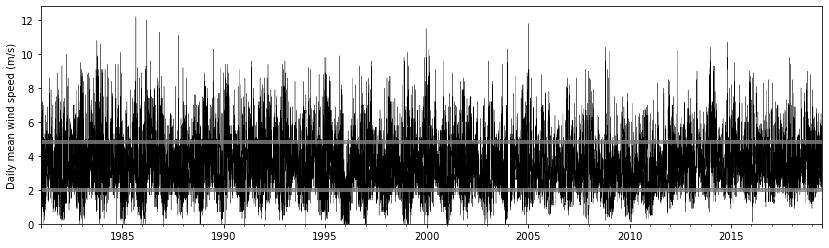

In [27]:
ax = daily_df.loc["1981-01-01":, "Wind_speed"].plot(figsize=(14, 4), lw=0.3, color="k")
plt.ylim(ymin=0)

color = "0.5"
lw = 4
ls = "-"
alpha = 0.8

for wind_perc in [2.0, 4.8]:  #2.9, 3.8,
    plt.axhline(y=wind_perc, color=color, lw=lw, linestyle=ls, alpha=alpha)

plt.xlabel("")
plt.ylabel("Daily mean wind speed (m/s)")

# A bit of exploring of relationships between variables

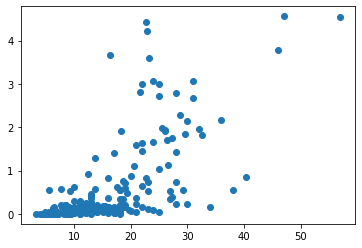

In [28]:
# Plot one variable against another

# plt.plot(np.log(daily_df['Q']), np.log(daily_df['TP_catch']),'o')
plt.plot(daily_df["chl-a_lake"], daily_df["CyanoBiovol"], "o")

In [29]:
# pd.plotting.scatter_matrix(daily_df, figsize=(12,12))
# plt.show()